# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Regressão-Softmax-(Iris-dataset)-implementação-matricial" data-toc-modified-id="Regressão-Softmax-(Iris-dataset)-implementação-matricial-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Regressão Softmax (Iris dataset) implementação matricial</a></div><div class="lev2 toc-item"><a href="#Objetivos" data-toc-modified-id="Objetivos-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Objetivos</a></div><div class="lev2 toc-item"><a href="#Classificador-Supervisionado" data-toc-modified-id="Classificador-Supervisionado-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Classificador Supervisionado</a></div><div class="lev2 toc-item"><a href="#Definição-do-problema" data-toc-modified-id="Definição-do-problema-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Definição do problema</a></div><div class="lev2 toc-item"><a href="#Importação-de-bibliotecas" data-toc-modified-id="Importação-de-bibliotecas-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Importação de bibliotecas</a></div><div class="lev2 toc-item"><a href="#Iris-Flower-Dataset" data-toc-modified-id="Iris-Flower-Dataset-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Iris Flower Dataset</a></div><div class="lev2 toc-item"><a href="#Escolhendo-os-dois-atributos" data-toc-modified-id="Escolhendo-os-dois-atributos-16"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Escolhendo os dois atributos</a></div><div class="lev2 toc-item"><a href="#Leitura-dos-dados" data-toc-modified-id="Leitura-dos-dados-17"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Leitura dos dados</a></div><div class="lev2 toc-item"><a href="#Imprimindo-os-dados-rotulados-com-pandas" data-toc-modified-id="Imprimindo-os-dados-rotulados-com-pandas-18"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Imprimindo os dados rotulados com pandas</a></div><div class="lev2 toc-item"><a href="#Visualizando-o-dataset" data-toc-modified-id="Visualizando-o-dataset-19"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>Visualizando o dataset</a></div><div class="lev2 toc-item"><a href="#Normalização-dos-dados" data-toc-modified-id="Normalização-dos-dados-110"><span class="toc-item-num">1.10&nbsp;&nbsp;</span>Normalização dos dados</a></div><div class="lev2 toc-item"><a href="#Visualização-dados-normalizados" data-toc-modified-id="Visualização-dados-normalizados-111"><span class="toc-item-num">1.11&nbsp;&nbsp;</span>Visualização dados normalizados</a></div><div class="lev2 toc-item"><a href="#Função-para-codificar-rótulos-inteiros-na-codificação-one-hot" data-toc-modified-id="Função-para-codificar-rótulos-inteiros-na-codificação-one-hot-112"><span class="toc-item-num">1.12&nbsp;&nbsp;</span>Função para codificar rótulos inteiros na codificação one-hot</a></div><div class="lev3 toc-item"><a href="#Gerando-vetor-de-rótulos-no-formato-one-hot" data-toc-modified-id="Gerando-vetor-de-rótulos-no-formato-one-hot-1121"><span class="toc-item-num">1.12.1&nbsp;&nbsp;</span>Gerando vetor de rótulos no formato one-hot</a></div><div class="lev2 toc-item"><a href="#Colocando-a-coluna-0-em-X-com-1s-como-o-'bias'" data-toc-modified-id="Colocando-a-coluna-0-em-X-com-1s-como-o-'bias'-113"><span class="toc-item-num">1.13&nbsp;&nbsp;</span>Colocando a coluna 0 em X com 1s como o 'bias'</a></div><div class="lev2 toc-item"><a href="#Função-softmax" data-toc-modified-id="Função-softmax-114"><span class="toc-item-num">1.14&nbsp;&nbsp;</span>Função <code>softmax</code></a></div><div class="lev2 toc-item"><a href="#Modelo-da-Regressão-Softmax-(uma-amostra-x)" data-toc-modified-id="Modelo-da-Regressão-Softmax-(uma-amostra-x)-115"><span class="toc-item-num">1.15&nbsp;&nbsp;</span>Modelo da Regressão Softmax (uma amostra x)</a></div><div class="lev2 toc-item"><a href="#Implementação-matricial-com-M-amostras" data-toc-modified-id="Implementação-matricial-com-M-amostras-116"><span class="toc-item-num">1.16&nbsp;&nbsp;</span>Implementação matricial com M amostras</a></div><div class="lev2 toc-item"><a href="#J:-Função-Perda-pela-Entropia-Cruzada" data-toc-modified-id="J:-Função-Perda-pela-Entropia-Cruzada-117"><span class="toc-item-num">1.17&nbsp;&nbsp;</span>J: Função Perda pela Entropia Cruzada</a></div><div class="lev2 toc-item"><a href="#Minimização-pelo-gradiente-descendente" data-toc-modified-id="Minimização-pelo-gradiente-descendente-118"><span class="toc-item-num">1.18&nbsp;&nbsp;</span>Minimização pelo gradiente descendente</a></div><div class="lev2 toc-item"><a href="#Laço-do-Treinamento-via-Gradiente-Descendente" data-toc-modified-id="Laço-do-Treinamento-via-Gradiente-Descendente-119"><span class="toc-item-num">1.19&nbsp;&nbsp;</span>Laço do Treinamento via Gradiente Descendente</a></div><div class="lev2 toc-item"><a href="#Este-é-o-laço-principal-da-Regressão-Logística-por-Softmax" data-toc-modified-id="Este-é-o-laço-principal-da-Regressão-Logística-por-Softmax-120"><span class="toc-item-num">1.20&nbsp;&nbsp;</span>Este é o laço principal da Regressão Logística por Softmax</a></div><div class="lev2 toc-item"><a href="#Visualizando-a-minimização-da-Perda-durante-o-treinamento" data-toc-modified-id="Visualizando-a-minimização-da-Perda-durante-o-treinamento-121"><span class="toc-item-num">1.21&nbsp;&nbsp;</span>Visualizando a minimização da Perda durante o treinamento</a></div><div class="lev2 toc-item"><a href="#Predição" data-toc-modified-id="Predição-122"><span class="toc-item-num">1.22&nbsp;&nbsp;</span>Predição</a></div><div class="lev2 toc-item"><a href="#Função-predict" data-toc-modified-id="Função-predict-123"><span class="toc-item-num">1.23&nbsp;&nbsp;</span>Função <code>predict</code></a></div><div class="lev2 toc-item"><a href="#Cálculo-do-desempenho-do-resultado" data-toc-modified-id="Cálculo-do-desempenho-do-resultado-124"><span class="toc-item-num">1.24&nbsp;&nbsp;</span>Cálculo do desempenho do resultado</a></div><div class="lev2 toc-item"><a href="#Matriz-de-confusão" data-toc-modified-id="Matriz-de-confusão-125"><span class="toc-item-num">1.25&nbsp;&nbsp;</span>Matriz de confusão</a></div><div class="lev2 toc-item"><a href="#Visualizando-as-regiões-do-classificador-no-espaço-de-atributos" data-toc-modified-id="Visualizando-as-regiões-do-classificador-no-espaço-de-atributos-126"><span class="toc-item-num">1.26&nbsp;&nbsp;</span>Visualizando as regiões do classificador no espaço de atributos</a></div><div class="lev2 toc-item"><a href="#Atividades" data-toc-modified-id="Atividades-127"><span class="toc-item-num">1.27&nbsp;&nbsp;</span>Atividades</a></div>

# Regressão Softmax (Iris dataset) implementação matricial

## Objetivos

Os objetivos deste notebook são 
* ilustrar a implementação, treino e uso de um classificador multiclasse utilizando 
* regressão logística e 
* componente softmax e
* minimização da função perda utilizando gradiente descendente. 

O conjunto de dados utilizados é o Iris, utilizando apenas 
* dois atributos para 
* visualização das fronteiras de decisão no espaço de atributos.

Como feito no experimento de Regressão Linear, as funções serão todas implementadas utilizando apenas o NumPy e serão uma extensão do problema de Regressão Linear.


## Classificador Supervisionado

O problema neste exemplo é um dos muitos que desenvolveremos neste curso e está na categoria de classificador supervisionado:

Dado um conjunto de amostras rotuladas, isto é, cada amostra será caracterizada pelos seus atributos e será representada na matriz $\mathbf{X}$ de shape $(n,k)$: ($n$ amostras e $k$ classes. Adicionalmente, cada amostra possui uma classe, um rótulo ou categoria, representado pelo vetor $\mathbf{Y}$ com $n$ elementos, cada um indicando a classe a qu pertence.

No caso da Iris, serão:
* 150 amostras, 50 da setosa (classe 0), virginica (classe 1) e versicolor (classe 2).

O par $(\mathbf{X},\mathbf{Y})$ consiste de um conjunto de dados anotados ou rotulados.

Uma das principais dificuldades no projeto de classificadores supervisionados é a criação deste banco anotado, pois demanda um esforço e conhecimento de peritos, muitas vezes tornando o problema inviável.

## Definição do problema

Dado o conjunto rotulado $(\mathbf{X},\mathbf{Y})$, projetar um classificador que dada uma nova amostra desconhecida, classifique-a em uma das possíveis classes: setosa, virginica ou versicolor.

Iremos utilizar uma solução baseada no experimento da Regressão Linear, porém agora, utilizando dois atributos e projetando o classificar para 3 classes. A minimização da função perda também será feita pelo método do gradiente descendente.

## Importação de bibliotecas

Objetivo deste exemplo é codificar o método de Regressão Logística utilizando Softmax e
gradiente descendente. As bibliotecas usadas são:
* NumPy - processamento matricial
* sklearn - apenas para carregar o dataset
* matplotlib - gerar gráficos
* pandas - mostrar a matriz de confusão
* IPython - permite mostrar os dados na forma de tabela


In [1]:
import numpy as np
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from IPython.display import display

## Iris Flower Dataset

[Wikipedia](https://en.wikipedia.org/wiki/Iris_flower_data_set): The data set consists of 50 samples from each of three species of Iris (*Iris setosa, Iris virginica and Iris versicolor*). Four features were measured from each sample: the **length and the width of the sepals and petals, in centimetres**. Based on the combination of these four features, Fisher developed a linear discriminant model to distinguish the species from each other.

## Escolhendo os dois atributos

Dos 4 atributos disponíveis: comprimento e largura das sépalas e comprimento e largura das pétalas, vamos escolher 2 apenas: o comprimento das sépalas e o comprimento das pétalas.

O conjunto de dados rotulados estão é formado por:
* Y: vetor de 150 amostras contendo o valor da classe da amostra: 0, 1 ou 2
* X: contendo 150 amostras (linhas) e duas colunas:
    * coluna 0: o comprimento das sépalas e 
    * coluna 1: comprimento das pétalas.
    

## Leitura dos dados

O trecho a seguir faz a leitura dos dados, escolha das duas colunas (0 e 2) e a impressão dos shapes de `X` e `Y`. Ambos formam nosso conjunto de dados anotados.

In [2]:
iris = load_iris()
X = iris.data[:,::2]  # comprimento das sépalas e pétalas, indices 0 e 2
Y = iris.target
print('X.shape:',X.shape)
print('Y.shape:',Y.shape)

X.shape: (150, 2)
Y.shape: (150,)


## Imprimindo os dados rotulados com pandas

O panda é um pacote extremamente poderoso para processamento e visualização de dados. Vamos utilizá-lo aqui para melhor visualizar os dados X e Y na forma de tabela.

In [3]:
# Assuming that dataframes df1 and df2 are already defined:
df = pd.DataFrame(X, index=Y, columns=['comprimento sepalas','comprimento petalas'])
df.columns.name = 'classe'
print('Imprimindo primeiros 5 amostras')
display(df.head()) # imprime o começo da tabela
print('Imprimindo 5 últimas amostras')
display(df.tail()) # imprime o final

Imprimindo primeiros 5 amostras


classe,comprimento sepalas,comprimento petalas
0,5.1,1.4
0,4.9,1.4
0,4.7,1.3
0,4.6,1.5
0,5.0,1.4


Imprimindo 5 últimas amostras


classe,comprimento sepalas,comprimento petalas
2,6.7,5.2
2,6.3,5.0
2,6.5,5.2
2,6.2,5.4
2,5.9,5.1


## Visualizando o dataset

Como feito no notebook passado, as amostras são visualizadas com o `scatter`. A cor de cada amostra é selecionada pela sua classe: 0: red, 1: yellow: 2: blue. A cor é indexada pelo vetor `Y` das classes.

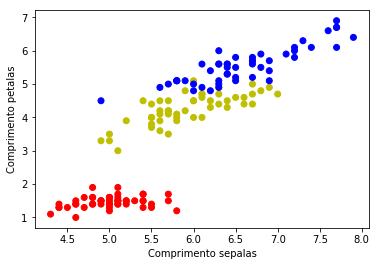

In [4]:
colors = np.array(['r','y','b'])
plt.scatter(X[:, 0], X[:, 1], c=colors[Y])
plt.xlabel('Comprimento sepalas')
plt.ylabel('Comprimento petalas')
plt.show()

## Normalização dos dados

A normalização dos dados quando existem mais de um atributo merece um cuidado, pois os limites dos valores mínimos e máximos devem ser feitos para cada atributo. Em NumPy isso é conseguido com a operação de redução de eixo onde é possível encontrar o máximo e o mínimo por colunas ou por linhas. No caso, como os atributos estão organizados por colunas, a redução deve ocorrer no eixo das linhas (axis=0):

Para se observar a diferença entre a normalização certa e que normaliza de forma global, fazemos as duas normalizações e visualizamos para observar a diferença.

In [5]:
# normalização global - não deve ser usada
X_a = X - X.min()
X_a /= X_a.max()

# normalização correta - por coluna
X_c = X - X.min(axis=0,keepdims=True)
X_c /= X_c.max(axis=0,keepdims=True)

## Visualização dados normalizados

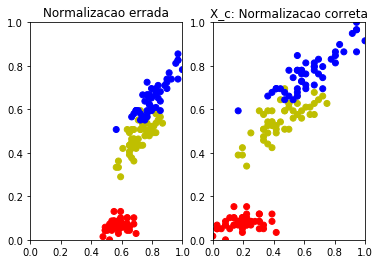

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
ax1.set_ylim(0,1)
ax1.set_xlim(0,1)
ax2.set_ylim(0,1)
ax2.set_xlim(0,1)
ax1.scatter(X_a[:, 0], X_a[:, 1], c=colors[Y])
ax2.scatter(X_c[:, 0], X_c[:, 1], c=colors[Y])
ax1.set_title('Normalizacao errada')
ax2.set_title('X_c: Normalizacao correta')

## Função para codificar rótulos inteiros na codificação one-hot

Esta função é também chamada de conversão para dados categóricos. Temos 3 classes de
flores: Iris setosa, Iris virginica and Iris versicolor. Estas classes podem ser codificadas
como classes 0, 1 e 2 (rótulos numéricos) ou na codificação com 3 variáveis binárias:

<table border="1">
<tr>
<td>Espécie</td>
<td>Y</td>
<td>Y_oh[0]</td>
<td>Y_oh[1]</td>
<td>Y_oh[2]</td>
</tr>
<tr>
<td>Iris setosa</td>
<td>0</td>
<td>1</td>
<td>0</td>
<td>0</td>
</tr>
<tr>
<td>Iris virginica</td>
<td>1</td>
<td>0</td>
<td>1</td>
<td>0</td>
</tr>
<tr>
<td>Iris versicolor</td>
<td>2</td>
<td>0</td>
<td>0</td>
<td>1</td>
</tr>
</table>



A função `oneHotIt` a seguir implementa de forma eficiente esta conversão, utilizando a
facilidade de criação de arrays esparsos.

A entrada da função é o vetor `Y` e a saída será um array com o mesmo número de
linhas que o número de elementos de `Y` e a largura terá o número de colunas do
maior rótulo disponível em `Y`:

A título de ilustração e exercício de programação matricial, apresentamos a seguir duas implementações da função que converte os labels para a codificação "one-hot":

In [7]:
def oneHotIt2(Y,n_classes):
    Y = Y.reshape(-1,1)
    i = np.arange(n_classes).reshape(1,n_classes)
    Y_oh = (Y == i).astype(int)
    return Y_oh

def oneHotIt(Y,n_classes):
    n_samples = Y.size # número de amostras
    i = np.arange(n_samples)
    Y_oh = np.zeros(shape=(n_samples,n_classes))
    Y_oh[i,Y] = 1
    return Y_oh

### Gerando vetor de rótulos no formato one-hot 

In [8]:
Y_oh = oneHotIt(Y,3)
# Mostrando os primeiros 5 destes valores
print('Y[:5]:\n', Y[:5])
print('Y_oh[:5]=\n',Y_oh[:5])
print('Y[-5:]:\n', Y[-5:])
print('Y_oh[-5:]=\n',Y_oh[-5:])

Y[:5]:
 [0 0 0 0 0]
Y_oh[:5]=
 [[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]]
Y[-5:]:
 [2 2 2 2 2]
Y_oh[-5:]=
 [[ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]]


## Colocando a coluna 0 em X com 1s como o 'bias'

Conforme visto no exercício da Regressão Linear, a equação linear de y em função de x0, x1, x_k tem um fator independente de x, denominado bias. Inserindo-se a coluna 0 de X com 1, é equivalente a definir o w0 como bias.

In [9]:
X_bias = np.hstack([np.ones((150,1)),X_c]) # incluído X com coluna de 1s para gerar bias no W
print('X_bias[:5]=\n',X_bias[:5])

X_bias[:5]=
 [[ 1.          0.22222222  0.06779661]
 [ 1.          0.16666667  0.06779661]
 [ 1.          0.11111111  0.05084746]
 [ 1.          0.08333333  0.08474576]
 [ 1.          0.19444444  0.06779661]]


## Função `softmax`

A funcão Softmax já foi vista antes:
Revisando, a implementação matricial usando o NumPy é baseado na equação matricial, repetida aqui:

$$ Softmax(\mathbf{Z}) = \frac{e^{\mathbf{Z}}}{\sum_{j=0}^{k-1}e^{z_{i,j}}} $$


In [10]:
def softmax(Z):
    # computes softmax for all samples, normalize among classes (columns)
    # input Z: scores; shape: samples rows x classes columns
    # output S: same shape of input
    EZ = np.exp(Z)
    S = EZ / EZ.sum(axis=1,keepdims=True) # normaliza nas classes - colunas
    return S

## Modelo da Regressão Softmax (uma amostra x)

Utilizamos o modelo da rede de Regressão Linear utilizada anteriormente para gerar os *scores* $\mathbf{z}$:
$$ \mathbf{z} = \mathbf{Wx} $$

Aplicamos a função Softmax para transformar os *scores* em probabilidade de ocorrência de cada classe:

$$ \mathbf{\hat{y}_{OH}} = S(\mathbf{z}) $$.

Desta forma, a rede fica como:

$$ \mathbf{\hat{y}_{OH}} = S(\mathbf{Wx}) $$

Gráficamente, pode ser representada pela rede de uma camada de 2 entradas, 3 classes (saídas de ativação Softmax):

<img src='../figures/RegressaoSoftmaxRede.png',width=600pt>

## Implementação matricial com M amostras

Igual feito no exemplo anterior, para se processar $M$ amostras simultaneamente, adota-se a 
formulação matricial conforme ilustrado na figura. O conjunto de dados é organizado na forma
de uma amostra por linha, tendo a primeira coluna os valores um's para associar ao *bias* e a
matriz de parâmetros $\mathbf{W}$ é usado na forma de transposto:
* $\mathbf{X}$: $M$ linhas com as amostras e $N$ colunas com os atributos
* $\mathbf{W}^T$: $K$ linhas associadas às classes e $N$ colunas associadas aos atributos
* $\mathbf{Y}_{OH}$: $M$ linhas com a predição das amostras e $K$ colunas, uma de cada classe

<img src="../figures/RegressaoSoftmaxMatricial.png",width=400pt>


## J: Função Perda pela Entropia Cruzada

A função a ser minimizada é a função $J$ de perda, que é baseada na Entropia Cruzada (*Cross Entropy*). Dado um conjunto de $M$ **amostras anotadas**, isto é, amostras $\mathbf{X}$ com
classe categórica $\mathbf{Y_{OH}}$, encontrar os pesos $\mathbf{W}$ que minimizam $J$:

$$ J_{\mathbf{X,Y_{TRUE}}}(\mathbf{W}) = -\frac{1}{M} \sum \mathbf{Y}_{OH} \odot \log{\mathbf{S(X \ W^T)}}$$
onde $\odot$ é multiplicação ponto-a-ponto de matrizes.

## Minimização pelo gradiente descendente

A minimização é feita através do método de gradiente descendente. O gradiente de $J$ é dado por:

$$ \nabla J(\mathbf{W}) = - \frac{1}{M} \mathbf{X}^T (\mathbf{Y}_{OH} - \mathbf{S(X\ W^T)}) $$ 

Os pesos são então ajustados em cada *batch* pela equação onde $\eta$ é denominado de
taxa de aprendizagem: *learning rate*:

$$ \mathbf{W} = \mathbf{W} - \eta \nabla J(\mathbf{W}) $$ 

A cada iteração no programa de minimização abaixo, os pesos são ajustados aplicando-se o
gradiente descendente utilizando todo o conjunto de treinamento. Este esquema é denominado
de "batch gradient descent".

No programa a seguir, o $J$ é implementado pela variável `loss` e o gradiente $\nabla J$ 
é implementado pela variável `Grad`.

## Laço do Treinamento via Gradiente Descendente

A figura a seguir ilustra o diagrama do classificador supervisionado multiclasse utilizando regressão softmax. Esta figura diz respeito a apenas uma amostra.

Podemos identificar os blocos responsáveis pelo treinamento do classificador:
* $\mathbf{(x,y)}$ são os dados de treinamento rotulados
* $\mathbf{W}$, são os parâmetros a serem treinados
* Softmax é o que converte os scores $\mathbf{z}$ de $\mathbf{wx}$ para probabilidades, gerando as
  probabilidades para cada classe: $\hat{y_{OH}}$
* OneHot converte o rótulo original numérico na codificação "one-hot" ou categórico
* $J$ é a função perda que compara $ \mathbf{y_{OH}}$ e $\mathbf{\hat{Y_{OH}}}$ a ser minimizada
* $\nabla_J$ é o gradiente que será utilizado para atualizar o $\mathbf{W}$ pelo método do gradiente descendente.


<img src='../figures/RegressaoSoftmax_Otimizacao.png',width=600pt>


## Este é o laço principal da Regressão Logística por Softmax

Os pesos são inicializados em zero, sem fator de regularização.
Em cada iteração, a função a ser minimizada é calculada e os pesos são ajustados
pelo técnica de gradiente descendente.

In [21]:
n_samples = X_bias.shape[0] # number of training examples
n_features = X_bias.shape[1] # number of attributes (features + 1(bias))
n_classes = 3          # number of classes
WT = np.zeros((n_features,n_classes)) # n. de linhas é igual a número de atributos (features, pixels)
iterations = 10000
learningRate = 0.15

losses = []
for i in range(iterations):
    scores = X_bias.dot(WT)
    Y_hat_oh = softmax(scores)
    loss = (-1. / n_samples) * np.sum(Y_oh * np.log(Y_hat_oh))
    Grad = (-1. / n_samples) * (X_bias.T).dot(Y_oh - Y_hat_oh) 
    WT = WT - (learningRate * Grad)
    losses.append(loss)
print('final W:\n',WT)
print('Final loss:',loss)

final W:
 [[  7.00966877   1.62753812  -8.63720689]
 [ -3.02197327   1.76353      1.25844327]
 [-14.71228144  -0.67161669  15.38389814]]
Final loss: 0.206986527354


## Visualizando a minimização da Perda durante o treinamento

É fundamental acompanhar o comportamento da Perda durante o treinamento, pois é difícil prever se os parâmetros do gradiente descendente estão bons.

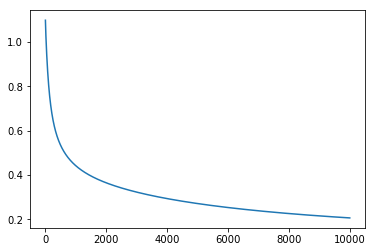

In [22]:
plt.plot(losses)

## Predição

Uma vez que $\mathbf{W}$ já seja treinado, a predição é a classe de maior probabilidade. Assim
a rede de propagação direta possuem os seguintes blocos:
* Softmax(XW) para calcular as probabilidades
* `Argmax` para escolher a classe de maior probabilidade

<img src="../figures/RegressaoSoftmaxArgmaxRede.png",width=600pt>

A função `predict` escolhe a classe de maior probabilidade a partir do resultado do `softmax`:

Entrada:
- X: matriz bidimensional (n_amostras,n_atributos): AMOSTRAS ROTULADAS
- WT: matriz bidimensional (n_atributos,n_classes): PESOS TREINADOS
Saída:
- Y_hat: matriz bidimensional (n_amostras,1): n amostras x 1 - CLASSE prevista para cada amostra


## Função `predict`

In [23]:
def predict(X,WT):
    Y_hat_oh = softmax(X.dot(WT))
    # escolhe a maior probabilidade entre as classes
    Y_hat = np.argmax(Y_hat_oh, axis=1)
    return Y_hat

## Cálculo do desempenho do resultado

A acurácia é o número de acertos dividido pelo número de amostras $M$.

$$ Acc(Y,\hat{Y}) = \frac{1}{M} \sum_{i=0}^{M-1} 1(Y_i = \hat{Y}_i) $$

In [24]:
Y_hat = predict(X_bias,WT)

accuracy = np.sum(Y_hat == Y)/np.float(n_samples)

print('Acurácia: ', accuracy)

Acurácia:  0.96


## Matriz de confusão

A matriz de confusão é uma tabulação muito prática para indicar os acertos e erros de um
classificador. As linhas indicam as classes preditas e as colunas as classes verdadeiras.
A diagonal da matriz de confusão indica os acertos.

In [25]:
import pandas as pd
pd.crosstab(Y_hat, Y)

col_0,0,1,2
row_0,,,
0,50,0,0
1,0,47,3
2,0,3,47


## Visualizando as regiões do classificador no espaço de atributos

Como são apenas 2 atributos, largura e comprimento das sépalas, é possível visualizar o espaço de atributos
num gráfico bidimensional e posicionar cada amostra rotulada, assim como rotular cada ponto do espaço de
atributos, podendo visualizar o projeto do classificador. Neste tipo de visualização é possível verificar
o comportamento do classificador e como ele divide o espaço de atributos. O classificador de Regressão Softmax
é um classificador linear e os espaço de atributo é dividido por linhas retas.

A função `FSView` permite esta visualização.

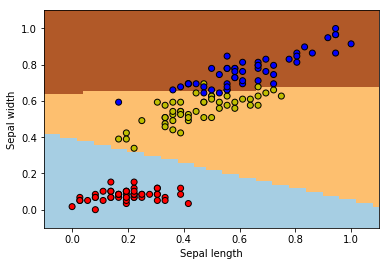

In [26]:
from Jview import FSView
FSView(X_bias,Y,WT)

## Atividades

1. O próximo notebook é similar a este, porém com a visualização simultânea do gráfico da perda e o gráfico das fronteiras de decisão. Faça as atividades neste próximo notebook e utilize este para entender os diversos passos do programa, pois aqui o notebook está bastante explicado.